In [1]:
%pip install pandas matplotlib numpy


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
human_ratings = {
    'Story': ['American Story Old Phoebe', 'American Story Birthday', 'American Story Flying', 'American Story Lottery', 'American Story Ylla'],
    'Suspense': [3.4, 3.2, 3.6, 4.5, 5.1],

}
#'Curiosity Past': [2.1, 3.2, 3.5, 3.9, 4.2],
    #'Curiosity Future': [4.0, 3.8, 3.8, 5.0, 5.2],
    #'Surprise': [2.8, 3.1, 3.5, 3.2, 4.1],
    #'Irony': [2.4, 2.8, 3.1, 2.7, 3.6]

In [4]:
import ast
import os
import pandas as pd
import json
from collections import defaultdict

def get_llm_ratings(llm_rating_sources: list[str]) -> dict[str, dict[str, list[float]]]:
    llm_ratings = defaultdict(lambda: defaultdict(list))  

    for source in llm_rating_sources:
        source_path = f"{os.path.dirname(os.path.abspath(os.getcwd()))}/../outputs/{source}"
        
        for root, _, files in os.walk(source_path):
            model_name = os.path.basename(os.path.dirname(root))
            
            for file in files:
                if file.endswith(".csv"):
                    file_path = os.path.join(root, file)
                    df = pd.read_csv(file_path, header=None, names=['experiment_name', 'version', 'response'])

                    for _, row in df.iterrows():
                        if 'Chunks' in row['version']:
                            story_name = row['version'].split(' Chunks')[0]
                            response = row["response"]
                            
                            try:
                                response_dict = json.loads(response.replace("'", "\""))
                            except json.JSONDecodeError:
                                try:
                                    response_dict = ast.literal_eval(response)
                                except (ValueError, SyntaxError):
                                    print(f"Skipping malformed response: {response}")
                                    continue  

                            selected_values = [response_dict.get(str(key)) for key in ['0', '3', '6', '9', '12']]
                            selected_values = [v for v in selected_values if v is not None]


                            if selected_values:
                                llm_ratings[model_name][story_name] = selected_values


    return llm_ratings




In [5]:
from collections import defaultdict
def average_ratings_across_sources(*llm_rating_sources):
    averaged_data = defaultdict(lambda: defaultdict(list))
    
    for source in llm_rating_sources:
        llm_ratings = get_llm_ratings(source)
        
        for model, stories in llm_ratings.items():
            for story, ratings_list in stories.items():
                if story not in averaged_data[model]:
                    averaged_data[model][story] = []
                
                averaged_data[model][story].append(ratings_list)
    
    for model, stories in averaged_data.items():
        for story, ratings_lists in stories.items():
            averaged_ratings = [
                sum(ratings) / len(ratings) for ratings in zip(*ratings_lists)
            ]
            averaged_data[model][story] = [round(rating, 2) for rating in averaged_ratings]
    
    return averaged_data

llm_rating_sources1 = ['brewer_experiment/final/paper/exp1']
llm_rating_sources2 = ['brewer_experiment/final/paper/exp2']
llm_rating_sources3 = ['brewer_experiment/final/paper/exp3']

averaged_llm_ratings = average_ratings_across_sources(llm_rating_sources1, llm_rating_sources2, llm_rating_sources3)

print(averaged_llm_ratings)


Skipping malformed response: { '0': 1, '1': 2, '2': 1, '3': 1, '4': 4, '5': 1, '6': None, '7': None, '8': None,  # Error - No Response '9': 1, '10': 2, '11': 1, '12': 3, '13': 4, '14': 3 }
defaultdict(<function average_ratings_across_sources.<locals>.<lambda> at 0x14440ed40>, {'mistralai_Mixtral-8x7B-Instruct-v0.1': defaultdict(<class 'list'>, {'American Story Old Phoebe': [4.0, 4.0, 4.0], 'American Story Ylla': [3.0, 5.0, 3.0, 3.0], 'American Story Flying': [5.0, 3.0, 5.0, 4.0, 2.0], 'American Story Birthday': [2.0, 3.0, 4.0, 1.0, 1.0], 'American Story Lottery': [1.0, 5.0]}), 'meta-llama_Llama-3-70b-chat-hf': defaultdict(<class 'list'>, {'American Story Old Phoebe': [1.0, 2.0, 2.0, 3.0, 5.0], 'American Story Lottery': [2.0, 3.0, 4.0, 5.0, 6.0], 'American Story Ylla': [6.0, 5.0, 6.0, 6.0, 6.0], 'American Story Flying': [1.0, 5.0, 6.0, 7.0, 1.0], 'American Story Birthday': [4.0, 3.0, 5.0, 4.0, 3.0]}), 'google_gemma-2-27b-it': defaultdict(<class 'list'>, {'American Story Old Phoebe': [3.

In [6]:
story_llm_ratings = defaultdict(lambda: defaultdict(list))

for llm, stories in averaged_llm_ratings.items():
    for story, ratings in stories.items():
        story_llm_ratings[story][llm] = ratings

story_llm_ratings = dict(story_llm_ratings)

print(story_llm_ratings)

{'American Story Old Phoebe': defaultdict(<class 'list'>, {'mistralai_Mixtral-8x7B-Instruct-v0.1': [4.0, 4.0, 4.0], 'meta-llama_Llama-3-70b-chat-hf': [1.0, 2.0, 2.0, 3.0, 5.0], 'google_gemma-2-27b-it': [3.0, 4.0, 1.0, 2.0, 5.0], 'Qwen_Qwen2-72B-Instruct': [4.0, 3.0, 3.0, 5.0, 5.0], 'mistralai_Mistral-7B-Instruct-v0.3': [4.0, 4.0, 4.0, 4.0, 4.0], 'google_gemma-2-9b-it': [4.0, 4.0, 3.0, 3.0, 2.0], 'meta-llama_Llama-3-8b-chat-hf': [4.0, 4.0, 4.0, 4.0, 4.0]}), 'American Story Ylla': defaultdict(<class 'list'>, {'mistralai_Mixtral-8x7B-Instruct-v0.1': [3.0, 5.0, 3.0, 3.0], 'meta-llama_Llama-3-70b-chat-hf': [6.0, 5.0, 6.0, 6.0, 6.0], 'google_gemma-2-27b-it': [5.0, 6.0, 7.0, 7.0, 5.0], 'Qwen_Qwen2-72B-Instruct': [5.0, 6.0, 6.0, 7.0], 'mistralai_Mistral-7B-Instruct-v0.3': [5.0, 5.0, 6.0, 5.0, 5.0], 'google_gemma-2-9b-it': [3.0, 4.0, 6.0, 6.0, 7.0], 'meta-llama_Llama-3-8b-chat-hf': [4.0, 4.0, 5.0, 6.0, 6.0]}), 'American Story Flying': defaultdict(<class 'list'>, {'mistralai_Mixtral-8x7B-Instruc

In [7]:
%pip install seaborn


Note: you may need to restart the kernel to use updated packages.


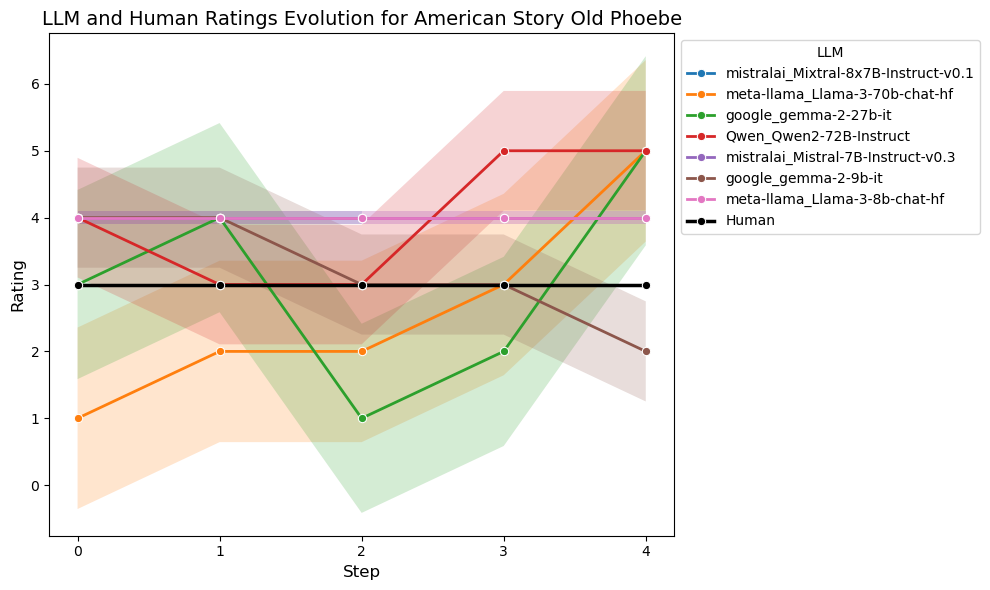

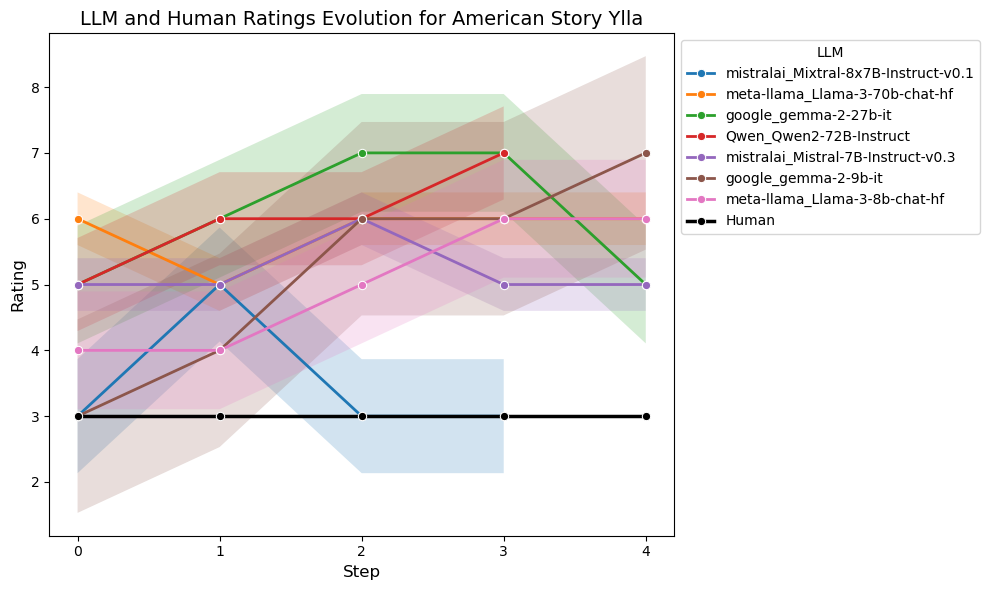

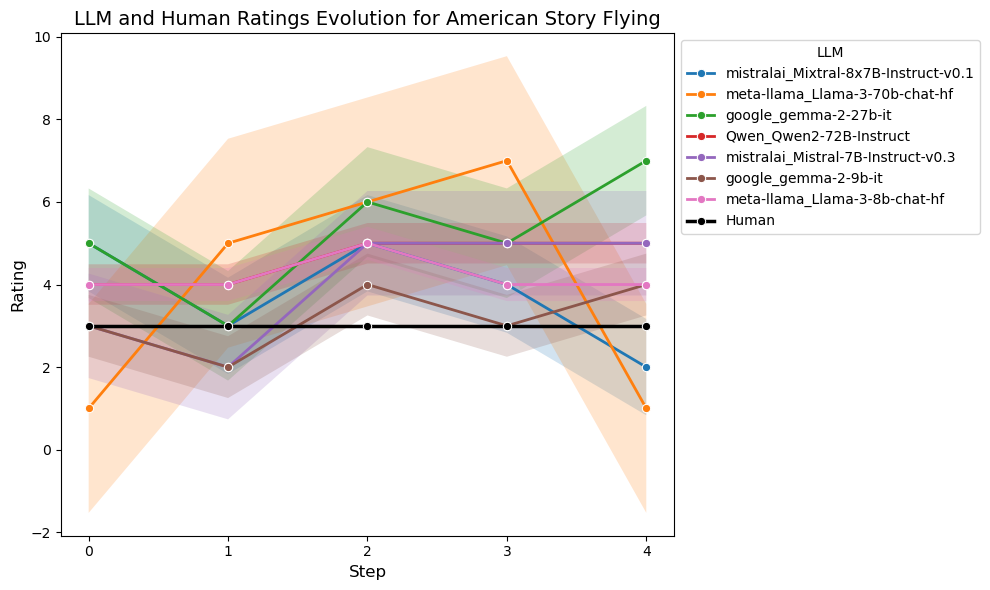

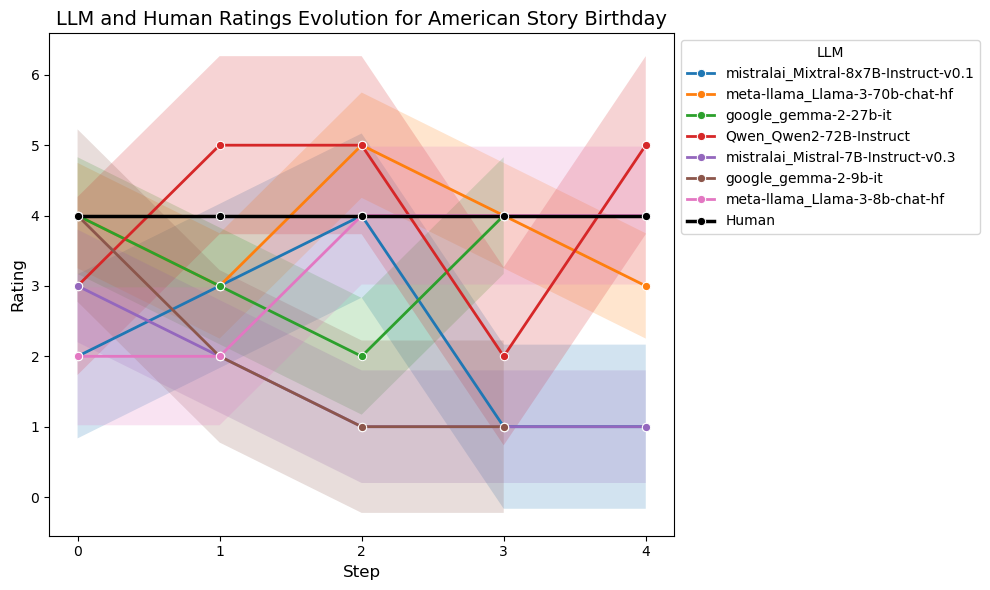

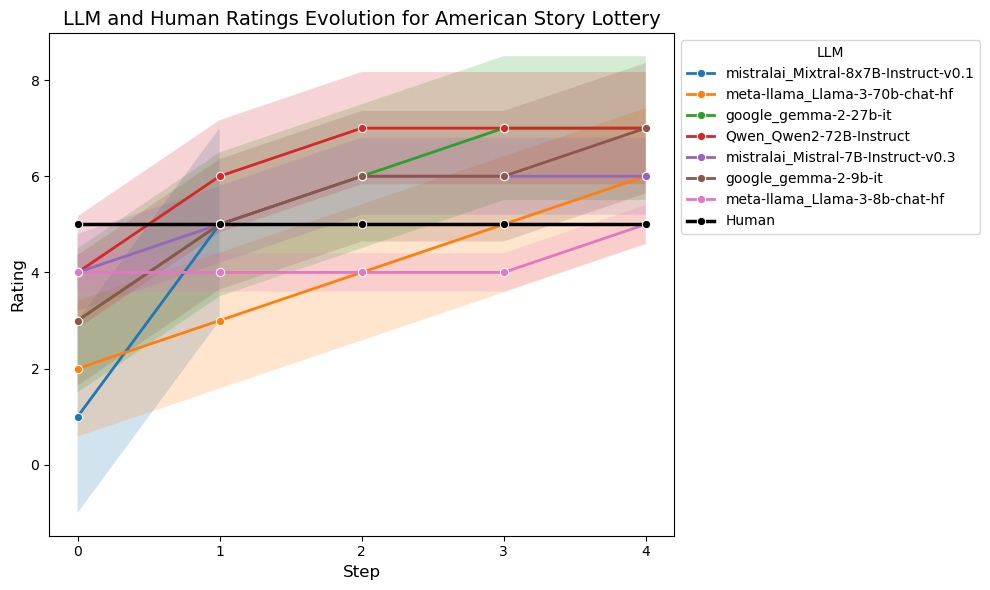

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

human_ratings = [3.4, 3.2, 3.6, 4.5, 5.1]  

for idx, (story, llm_data) in enumerate(story_llm_ratings.items()):
    plt.figure(figsize=(10, 6))
    for llm, ratings in llm_data.items():
        steps = np.array(range(len(ratings)))
        mean_ratings = np.array(ratings)
        std_dev = np.std(mean_ratings)
        min_ci = 0.1
        lower_bound = mean_ratings - np.maximum(std_dev, min_ci)
        upper_bound = mean_ratings + np.maximum(std_dev, min_ci)
        plt.fill_between(steps, lower_bound, upper_bound, alpha=0.2)
        sns.lineplot(x=steps, y=mean_ratings, label=llm, marker="o", linewidth=2)
    human_steps = np.array(range(5))
    human_mean = np.full_like(human_steps, human_ratings[idx])
    sns.lineplot(
        x=human_steps, 
        y=human_mean, 
        label="Human", 
        marker="o", 
        linewidth=2.5, 
        color="black"
    )
    plt.title(f'LLM and Human Ratings Evolution for {story}', fontsize=14)
    plt.xlabel('Step', fontsize=12)
    plt.ylabel('Rating', fontsize=12)
    plt.legend(title='LLM', loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(sorted(steps))  
    plt.tight_layout()
    plt.show()


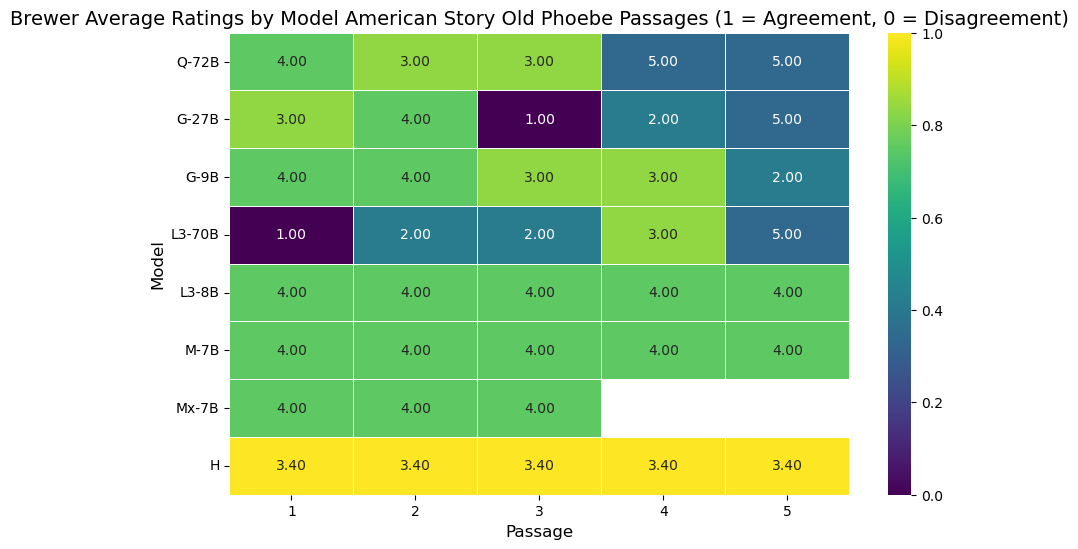

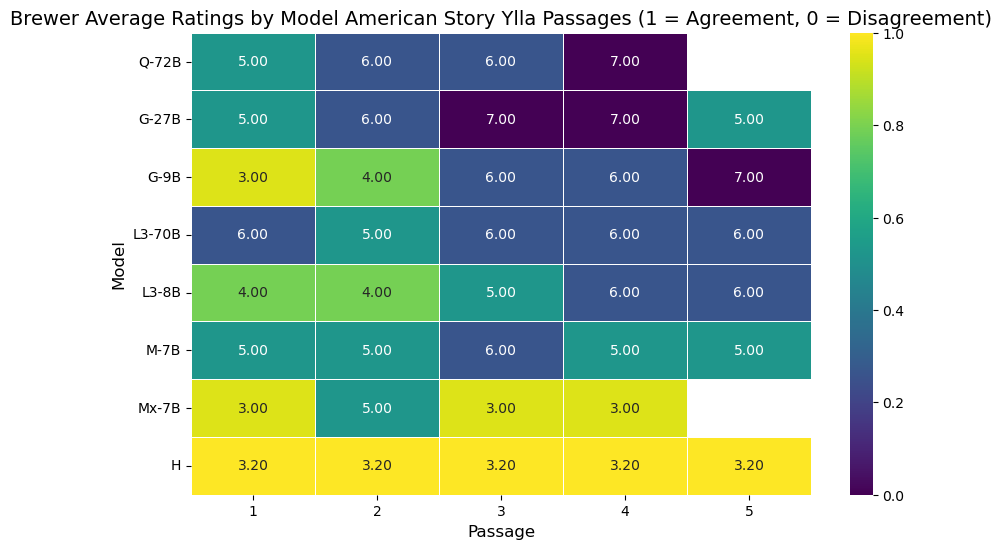

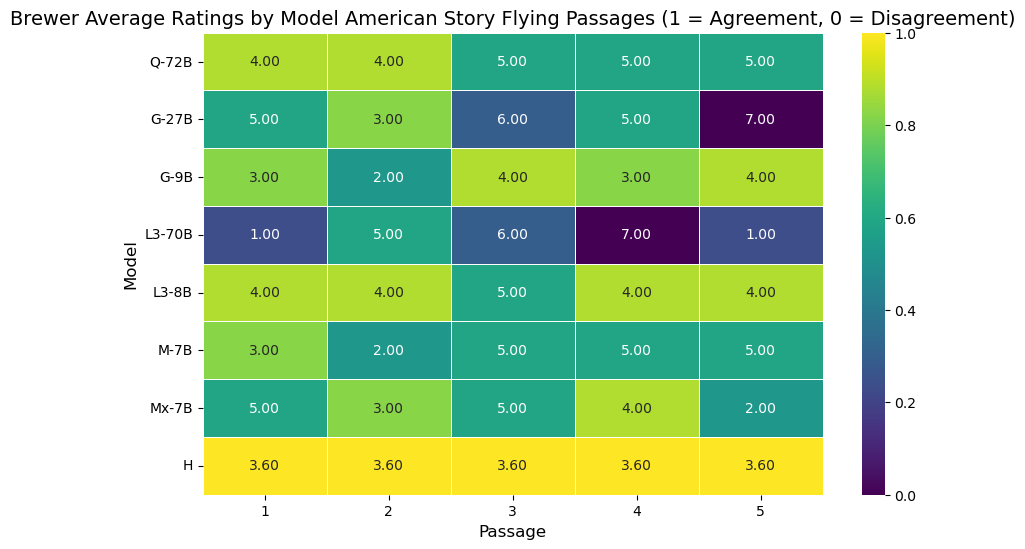

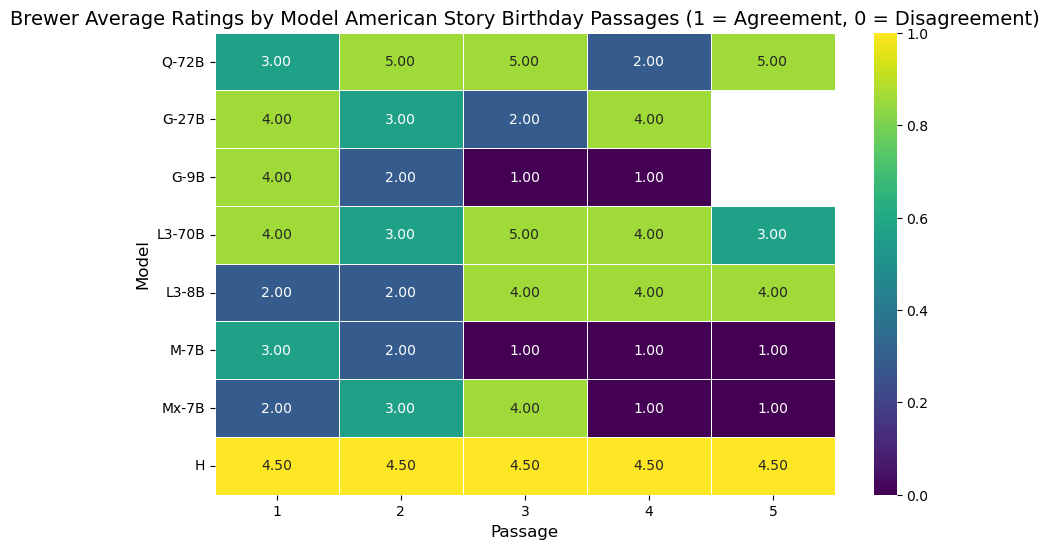

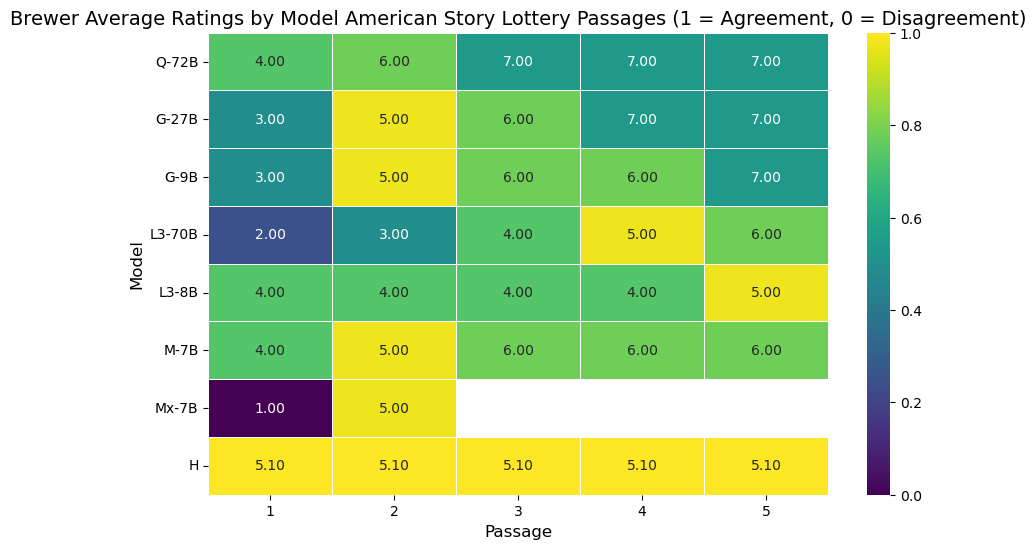

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

human_ratings = [3.4, 3.2, 3.6, 4.5, 5.1]
llm_names = list(next(iter(story_llm_ratings.values())).keys()) 
shortened_model_names = ["Q-72B", "G-27B", "G-9B", "L3-70B", "L3-8B", "M-7B", "Mx-7B"]


for idx, (story, llm_data) in enumerate(story_llm_ratings.items()):
    data = []
    actual_values = []
    deviations = []
    llm_ratings = []

    for llm, ratings in llm_data.items():
        for step, rating in enumerate(ratings):
            deviation = abs(rating - human_ratings[idx])
            data.append([llm, step, deviation])
            actual_values.append([llm, step, rating])
            deviations.append(deviation)
            llm_ratings.append(rating)

    llm_ratings = np.array(llm_ratings + human_ratings[idx:idx + 1])

    max_diff = np.max(np.abs(llm_ratings - human_ratings[idx])) if max(deviations) != 0 else 1
    agreement_matrix = 1 - (np.abs(llm_ratings - human_ratings[idx]) / max_diff)

    df = pd.DataFrame(data, columns=["LLM", "Step", "Deviation"])
    df_pivot = df.pivot(index="LLM", columns="Step", values="Deviation")
    
    df_pivot_normalized = 1 - (df_pivot / max_diff)

    human_row = pd.DataFrame([human_ratings], index=["H"], columns=df_pivot.columns)
    df_pivot = pd.concat([df_pivot, human_row])
    df_pivot_normalized = pd.concat([df_pivot_normalized, pd.DataFrame([[1]*len(df_pivot.columns)], index=["H"], columns=df_pivot.columns)])

    df_annotations = pd.DataFrame(actual_values, columns=["LLM", "Step", "Rating"]).pivot(index="LLM", columns="Step", values="Rating")
    human_annotations = pd.DataFrame([[human_ratings[idx]] * len(df_annotations.columns)], index=["H"], columns=df_annotations.columns)
    df_annotations = pd.concat([df_annotations, human_annotations])
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_pivot_normalized, annot=df_annotations, cmap="viridis", fmt=".2f", linewidths=0.5,yticklabels=shortened_model_names + ["H"], xticklabels=[1,2,3,4,5])
    
    plt.title(f'Brewer Average Ratings by Model {story} Passages (1 = Agreement, 0 = Disagreement)', fontsize=14)
    plt.xlabel('Passage', fontsize=12)
    plt.ylabel('Model', fontsize=12)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.show()


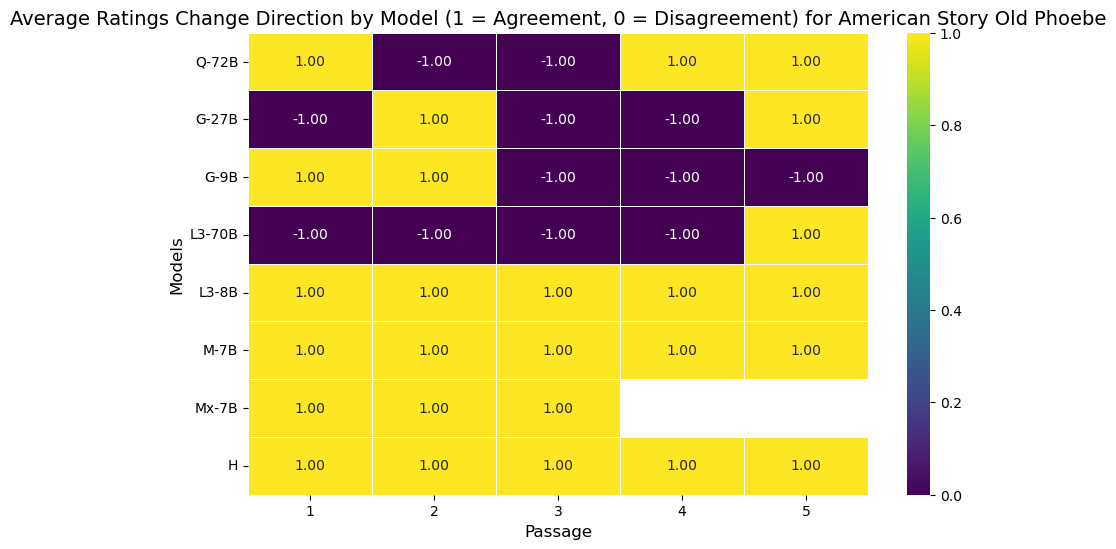

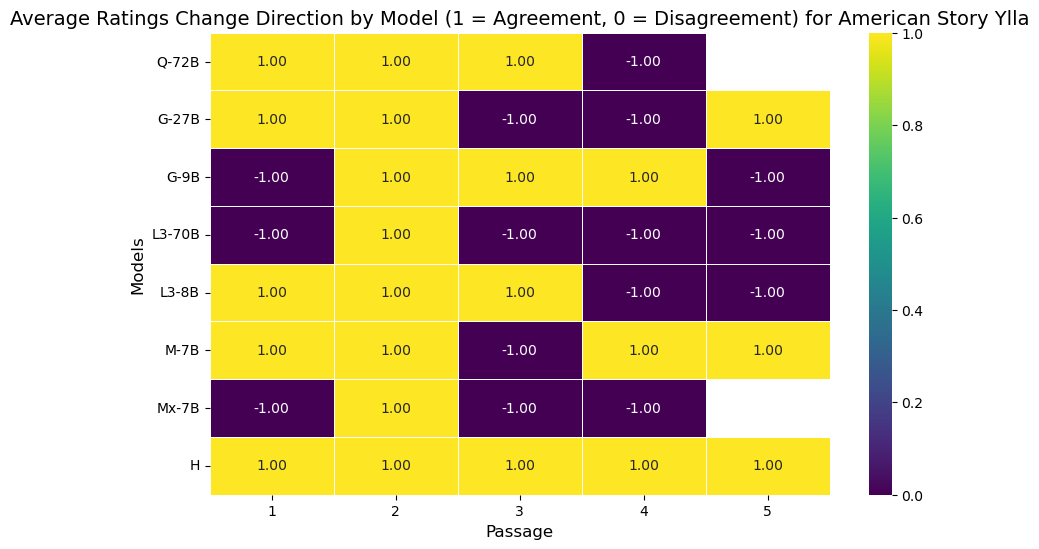

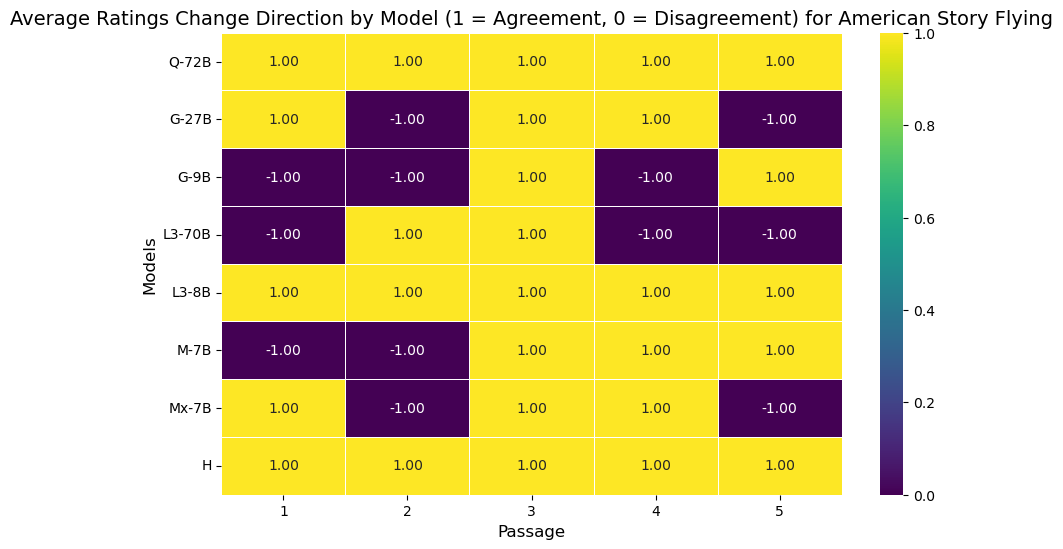

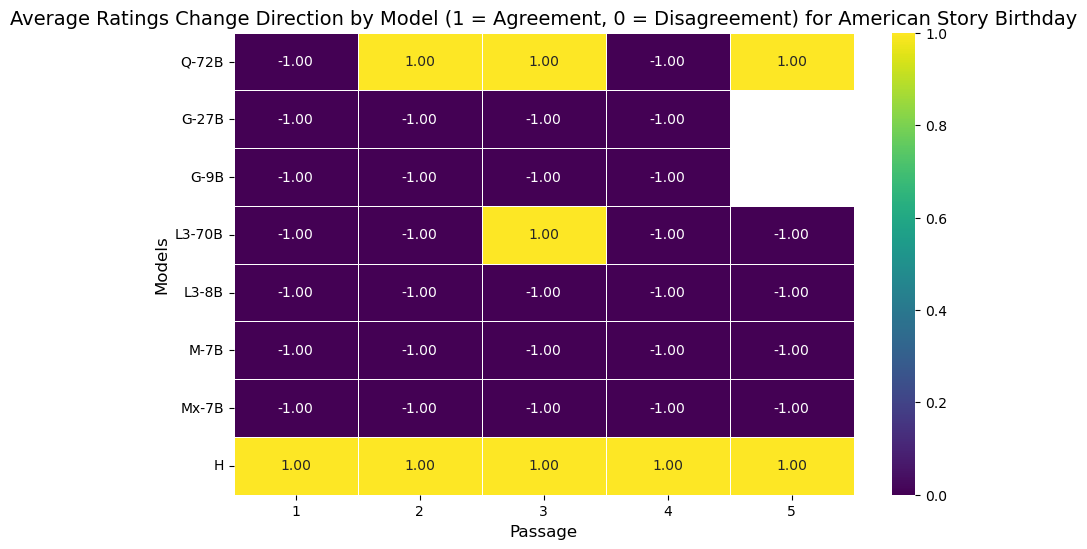

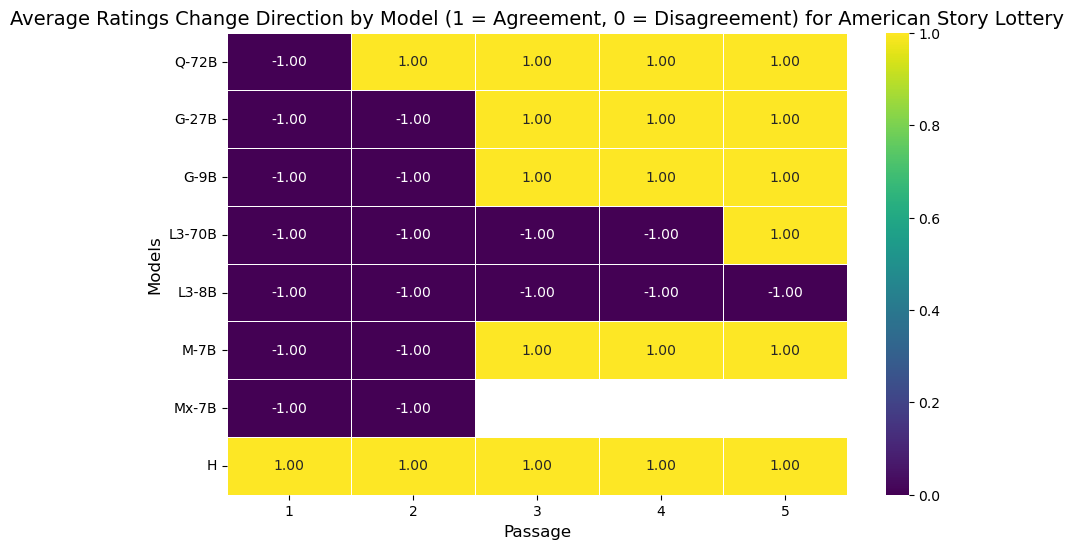

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

human_ratings = [3.4, 3.2, 3.6, 4.5, 5.1]
shortened_model_names = ["Q-72B", "G-27B", "G-9B", "L3-70B", "L3-8B", "M-7B", "Mx-7B"]

for idx, (story, llm_data) in enumerate(story_llm_ratings.items()):
    data = []
    data_show = []
    for llm, ratings in llm_data.items():
        max_r = max(ratings)
        for step, rating in enumerate(ratings):
            deviation = 1- ((abs(rating - human_ratings[idx]))/max_r)
            dev = rating - human_ratings[idx]
            if  dev > 0 and deviation > 0.6:
                deviation = 1
                dev = 1
            elif deviation == 0:
                deviation = 0.5
                dev = 0
            else:
                deviation = 0
                dev = -1
            data.append([step, llm, deviation])
            data_show.append([step, llm, dev])
    
    for step in range(5):
        data.append([step, "Human", 1])
        data_show.append([step, "Human", 1])
    
    df = pd.DataFrame(data, columns=["Step", "LLM", "Deviation"])
    df_show = pd.DataFrame(data_show, columns=["Step", "LLM", "Deviation"])
    df_show_pivot = df_show.pivot(index="Step", columns="LLM", values="Deviation").T
    df_pivot = df.pivot(index="Step", columns="LLM", values="Deviation").T
    df_pivot = df_pivot.loc[[llm for llm in df_pivot.index if llm != "Human"] + ["Human"]]
    df_show_pivot = df_show_pivot.loc[df_pivot.index] 

    plt.figure(figsize=(10, 6))
    sns.heatmap(df_pivot, cmap="viridis", annot=df_show_pivot, fmt=".2f", linewidths=0.5, cbar=True, yticklabels=shortened_model_names + ["H"], xticklabels=[1,2,3,4,5], vmax=1, vmin=0)
    plt.title(f'Average Ratings Change Direction by Model (1 = Agreement, 0 = Disagreement) for {story}', fontsize=14)
    plt.xlabel('Passage', fontsize=12)
    plt.ylabel('Models', fontsize=12)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.show()



In [11]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# human_ratings = [3.4, 3.2, 3.6, 4.5, 5.1]

# center_value = 3.5

# for idx, (story, llm_data) in enumerate(story_llm_ratings.items()):
#     data = []
#     for llm, ratings in llm_data.items():
#         for step, rating in enumerate(ratings):
#             data.append([step, llm, rating])
#         human_rating = human_ratings[idx]
#     for step in range(5):
#         data.append([step, "Human", human_rating])
#     df = pd.DataFrame(data, columns=["Step", "LLM", "Rating"])
#     df_pivot = df.pivot(index="Step", columns="LLM", values="Rating").T
#     df_pivot = df_pivot.loc[[llm for llm in df_pivot.index if llm != "Human"] + ["Human"]]
#     plt.figure(figsize=(10, 6))
#     sns.heatmap(df_pivot, cmap="viridis", annot=True, fmt=".2f", linewidths=0.5, cbar=True, center=center_value, vmin=1, vmax=7)
#     plt.title(f'Suspense Heatmap for {story}', fontsize=14)
#     plt.xlabel('Step', fontsize=12)
#     plt.ylabel('LLM', fontsize=12)
#     plt.xticks(rotation=90)
#     plt.yticks(rotation=0)
#     plt.show()
